# Load FIRE Data


In [216]:
# Import the main analysis module
import gizmo_analysis as gizmo

In [217]:
# Choose the simulation directory
simulation_directory = '/home/jovyan/fire2/m12i'

In [218]:
# read star particles and gas cells at z = 0
part = gizmo.io.Read.read_snapshots(['star', 'dark'], 'redshift', 0, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  home/jovyan/fire2/m12i/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/fire2/m12i/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'dark']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  home/jovyan/fire2/m12i/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties


# in gizm

# Extract parameters from FIRE

In [981]:
# Display keys
print( part.keys() )
print( part['star'].keys() )
print( part['dark'].keys() )

dict_keys(['star', 'dark'])
dict_keys(['position', 'mass', 'massfraction', 'id.child', 'id.generation', 'id', 'potential', 'form.scalefactor', 'velocity'])
dict_keys(['position', 'mass', 'id.child', 'id.generation', 'id', 'potential', 'velocity'])


In [982]:
# Declare parameters for star and dark matter particles
starPos = part['star'].prop('host.distance') # star position in kpc
starMass = part['star']['mass']              # star mass in Msun
starVel = part['star'].prop('host.velocity') # star velocity in km/s

darkPos = part['dark'].prop('host.distance') # dark position in kpc
darkMass = part['dark']['mass']              # dark mass in Msun
darkVel = part['dark'].prop('host.velocity') # dark velocity in km/s

In [983]:
# Temporary unit conversion from km/s to kpc/Gyr (ie. pc/Myr)
# kmsInPcMyr = 1.0227121655399913
# starVel = starVel * kmsInPcMyr
# darkVel = darkVel * kmsInPcMyr

# Graph density plots and find coefs

In [984]:
# Import modules for graphing 
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Import modules for curve fitting
import scipy
from scipy.optimize import curve_fit

Note: in both graphing codes below:
* edges = bin edges of the histogram computed for the radial data
* edges[1:] = all the bin edges except for the lower edge of the first bin
* edges[:-1] = all bin edges except for the upper edge of the last bin

In [985]:
# Define the bin edges
rmin = 0  # minimum radius
rmax = 200  # maximum radius
bins = 200  # number of bins

### Star density profile

/tmp/ipykernel_518/229675030.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(rmin, rmax)


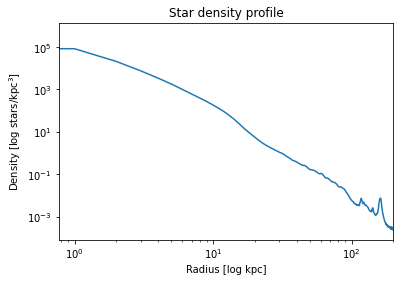

In [986]:
# Compute radial distance
starRadial = np.sqrt((starPos[:,0])**2 + (starPos[:,1])**2 + (starPos[:,2])**2)

# Compute the density profile
starCounts, starEdges = np.histogram(starRadial, bins=bins, range=(rmin, rmax))
starVolume = 4.0/3.0 * np.pi * (np.power(starEdges[1:], 3) - np.power(starEdges[:-1], 3))
starDensity = starCounts / starVolume

# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(starEdges[:-1], starDensity)
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
plt.title('Star density profile')
plt.show()

### Calculate gamma from the star population

In [987]:
# Objective function
def objective(r, gamma):
 return np.power(r,-gamma)

# Call curve_fit 
popt, pcov = curve_fit(objective, starEdges[1:], starDensity)

# Assign gamma from the stellar data fit
gamma = popt[0]
print("Gamma = ", gamma)

# Try log fitting instead

Gamma =  -0.5617534010051383


### Calculate beta from the star population

In [988]:
# Import modules to calculate beta
import beta as b

# Call beta function to calculate anisotropy from 3d pos and vel arrays
beta = b.beta(starPos, starVel)
print("Beta = ", beta)

Beta =  0.12881259099244435


### Dark matter density profile

/tmp/ipykernel_518/2463070414.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(rmin, rmax)


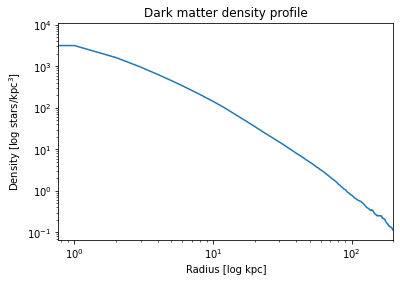

In [989]:
# Compute radial distance
darkRadial = np.sqrt((darkPos[:,0])**2 + (darkPos[:,1])**2 + (darkPos[:,2])**2)

# Compute the density profile
darkCounts, darkEdges = np.histogram(darkRadial, bins=bins, range=(rmin, rmax))
darkVolume = 4.0/3.0 * np.pi * (np.power(darkEdges[1:], 3) - np.power(darkEdges[:-1], 3))
darkDensity = darkCounts / darkVolume

# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(darkEdges[:-1], darkDensity)
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
plt.title('Dark matter density profile')
plt.show()

### Calculate alpha from dark matter population

In [990]:
# Objective function
def objective(r, gammaDark):
 return np.power(r,-gammaDark)

# Call curve_fit 
popt, pcov = curve_fit(objective, darkEdges[1:], darkDensity)

# Assign gamma
gammaDark = popt[0]

# Calculate alpha 
alpha = gammaDark - 2
print("Alpha = ", alpha)

Alpha =  -2.3797642325714556


**Alpha:**  

$\phi(r) =  \frac{v_0^2}{\alpha}\left(\frac{a}{r}\right)^\alpha$  

with $-1 \le \alpha \le 1$  
($\alpha \ge -2$ permited)

$\alpha = 0$: particles orbiting point mass  
$\alpha = 1$: satellites moving in a large-scale mass distribution with a flat rotation curve  
$\alpha = \gamma - 2$: satellites track the total gravitating mass  
  
**Beta:**  

$\beta = 1 - \sigma_t^2 / \sigma_r^2$  

$\beta \rightarrow \infty$: circular orbit model  
$\beta = 1$: purely radial orbits  
$\beta = 0$: isotropic case  

**Gamma:**  

$\rho(r) \propto r^{-\gamma}$  

$\frac{d\log \rho}{d\log r} = -\gamma$

In [991]:
print("Calculated alpha: ", alpha, "   Expected: 0.55")
print("Calculated beta:  ", beta,  "   Expected: 0 to infinity")
print("Calculated gamma: ", gamma, "   Expected: 2.6")

Calculated alpha:  -2.3797642325714556    Expected: 0.55
Calculated beta:   0.12881259099244435    Expected: 0 to infinity
Calculated gamma:  -0.5617534010051383    Expected: 2.6


### Calculate and graph beta as a function of distance

In [992]:
# Call binned beta function 
betaRadius, betaValues = b.beta_r(starPos, starVel, n_bins=100, rmax=rmax)

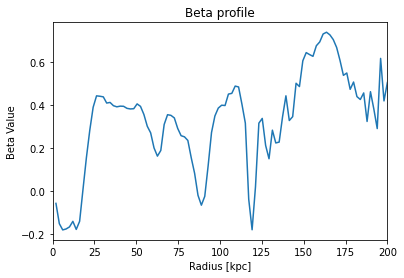

In [993]:
# Graph binned beta
fig, ax = plt.subplots()
ax.plot(betaRadius[1:], betaValues)
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Beta Value')
ax.set_xlim(rmin, rmax)
plt.title('Beta profile')
plt.show()

In [994]:
# Set beta to use beta array instead of float
beta = betaValues

# Using mass estimator

In [1123]:
# Import mass estimator 
import mass_estimators

In [1124]:
# Force values for now
alpha = 1.22
beta = 0.0
gamma = 3.7

In [1125]:
# If the beta array is used, update the bin size
if (type(beta) == np.ndarray):
    nbin = len(beta)

In [1148]:
# Call the profile estimator for stars
# radius = galactocentric distance bins [kpc]
# mass_v = enclosed mass profile computed with 3d velocities [Msun/1E10]
# mass_vr = enclosed mass profile computed with radial velocities [Msun/1E10]
star_radius, star_mass_v, star_mass_vr = mass_estimators.mass_estimator_profile(alpha, beta, gamma, starPos, starVel, rmin, rmax, nbins=bins)

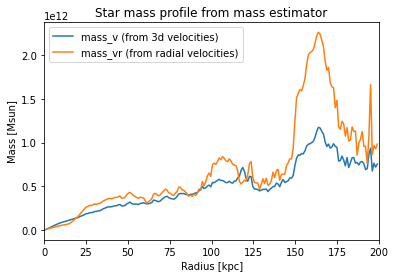

In [1152]:
# Plot the star mass profile in shells
fig, ax = plt.subplots()
ax.plot(star_radius, star_mass_v[:-1]*1E10, label='mass_v (from 3d velocities)')
ax.plot(star_radius, star_mass_vr[:-1]*1E10, label='mass_vr (from radial velocities)')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Star mass profile from mass estimator')
plt.show()

In [1153]:
# Call the profile estimator for dark matter
dark_radius, dark_mass_v, dark_mass_vr = mass_estimators.mass_estimator_profile(alpha, beta, gamma, darkPos, darkVel, rmin, rmax, nbins=bins)

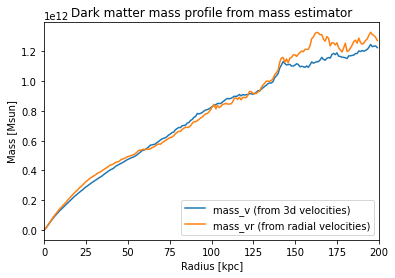

In [1154]:
# Plot the dark matter mass profile in shells
fig, ax = plt.subplots()
ax.plot(dark_radius, dark_mass_v[:-1]*1E10, label='mass_v (from 3d velocities)')
ax.plot(dark_radius, dark_mass_vr[:-1]*1E10, label='mass_vr (from radial velocities)')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
ax.legend(loc=4)
plt.title('Dark matter mass profile from mass estimator')
plt.show()

# Using FIRE mass 

In [1142]:
# Declare function to calculate cumulative mass
def cumulative(mass, pos, n_bins, rmax):
    dr = np.linspace(0, rmax, n_bins)
    r = (pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)**0.5
    mass_dr = np.zeros(len(dr)-1)
    for i in range(len(dr)-1):
        index = np.where((r<dr[i+1]) & (r>dr[i]))
        mass_dr[i] = np.sum(mass[index])
    return dr, mass_dr

In [1143]:
# Calculate FIRE cumulative star mass
starFireRadius, starFireMass= cumulative(starMass, starPos, n_bins=bins, rmax=rmax)

In [1144]:
# Calculate FIRE cumulative dark matter mass
darkFireRadius, darkFireMass= cumulative(darkMass, darkPos, n_bins=bins, rmax=rmax)

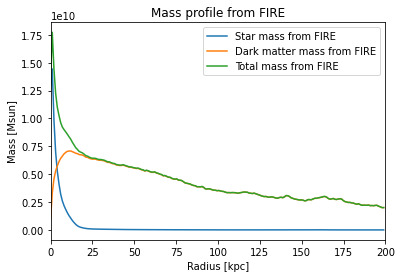

In [1224]:
# Plot the expected mass from FIRE
fig, ax = plt.subplots()
ax.plot(starFireRadius[:-1], starFireMass, label='Star mass from FIRE')
ax.plot(darkFireRadius[:-1], darkFireMass, label='Dark matter mass from FIRE')
ax.plot(starFireRadius[:-1], starFireMass + darkFireMass, label='Total mass from FIRE')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Mass profile from FIRE')
plt.show()

# Using built-in FIRE functions

In [1227]:
# Import the required utilities package
import utilities as ut

In [1228]:
# Linear binning from 0 to 200 kpc with 1 kpc bin width, assuming a 3-D profile
SpeciesProfile = ut.particle.SpeciesProfileClass(
    limits=[0, 200], width=1, log_scale=False, dimension_number=3)

In [1229]:
# Uncomment for additional information about FIRE profiles
#ut.particle.SpeciesProfileClass?

In [1230]:
# Using this binning scheme, compute sum/histogram/density of mass of star particles in each bin
# this returns a bunch of summed properties via a dictionary
proStar = SpeciesProfile.get_sum_profiles(part, 'star', 'mass')


# in utilities.particle.SpeciesProfile():
  input 13976485 distances - 12186458 (87.2%) are within limits = [0.000, 200.000]


In [1231]:
# Uncomment for additional information about sum profiles
#SpeciesProfile.get_sum_profiles?

In [1232]:
# Display the keys: 'baryon' is the sum total of stars + gas, 'total' is the sum total of all particle species
proStar.keys()

dict_keys(['star', 'baryon', 'total'])

In [1233]:
# Display the quantities that it stores in each bin
proStar['star'].keys()

dict_keys(['sum', 'sum.cum', 'log sum', 'log sum.cum', 'density', 'log density', 'density.cum', 'log density.cum', 'density.norm', 'log density.norm', 'density*r', 'log density*r', 'density*r^2', 'log density*r^2', 'fraction', 'log fraction', 'fraction.cum', 'log fraction.cum', 'distance.mid', 'distance.cum', 'log distance.mid', 'log distance.cum', 'sum.fraction', 'sum.cum.fraction', 'vel.circ'])

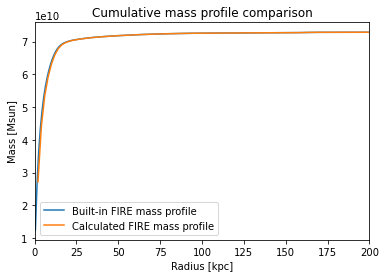

In [1234]:
# Plot the combined FIRE profile
fig, ax = plt.subplots()
ax.plot(proStar['star'].get('distance.mid'),proStar['star'].get('sum.cum'), label='Built-in FIRE mass profile')
ax.plot(fireRadius[1:], np.cumsum(fireMass), label='Calculated FIRE mass profile')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Cumulative mass profile comparison')
plt.show()

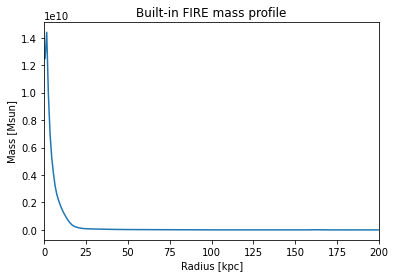

In [1235]:
# Plot the FIRE profile
fig, ax = plt.subplots()
ax.plot(proStar['star'].get('distance.mid'),proStar['star'].get('sum'))
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
plt.title('Built-in FIRE mass profile')
plt.show()

In [1236]:
# Repeat the process above for dark matter
proDark = SpeciesProfile.get_sum_profiles(part, 'dark', 'mass')

  input 70514272 distances - 23019655 (32.6%) are within limits = [0.000, 200.000]


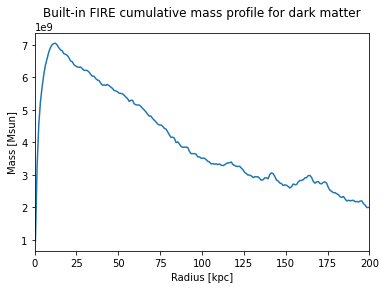

In [1237]:
# Plot the FIRE profile
fig, ax = plt.subplots()
ax.plot(proDark['dark'].get('distance.mid'),proDark['dark'].get('sum'))
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
plt.title('Built-in FIRE cumulative mass profile for dark matter')
plt.show()

# Combined mass density profile

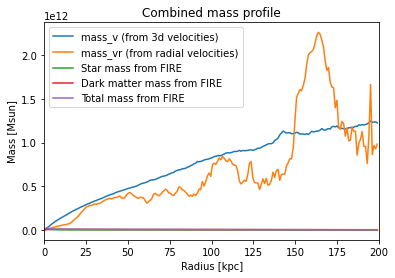

In [1238]:
# Plot the expected mass from FIRE
fig, ax = plt.subplots()
ax.plot(radius, mass_v[:-1]*1E10, label='mass_v (from 3d velocities)')
ax.plot(radius, mass_vr[:-1]*1E10, label='mass_vr (from radial velocities)')
ax.plot(starFireRadius[:-1], starFireMass, label='Star mass from FIRE')
ax.plot(darkFireRadius[:-1], darkFireMass, label='Dark matter mass from FIRE')
ax.plot(darkFireRadius[:-1], starFireMass + darkFireMass, label='Total mass from FIRE')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Mass [Msun]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Combined mass profile')
plt.show()

# Check density profile using built-in FIRE functions

/tmp/ipykernel_518/360142284.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(rmin, rmax)


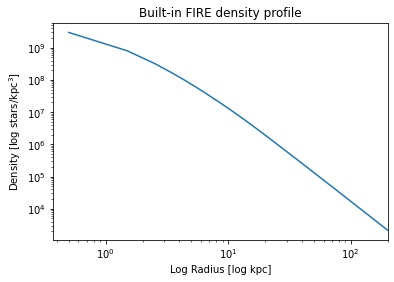

In [1239]:
# Plot the FIRE profile
fig, ax = plt.subplots()
ax.loglog(proStar['star'].get('distance.mid'),proStar['star'].get('density.cum'))
ax.set_xlabel('Log Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
plt.title('Built-in FIRE density profile')
plt.show()

In [1240]:
# Objective function
def objective(r, gamma):
 return np.power(r,-gamma)

# Call curve_fit 
popt, pcov = curve_fit(objective,proStar['star'].get('distance.mid'),proStar['star'].get('density.cum'))

# Assign gamma
gammaFire = popt[0]
print(gammaFire)

1.0


/tmp/ipykernel_518/1175714560.py:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(rmin, rmax)


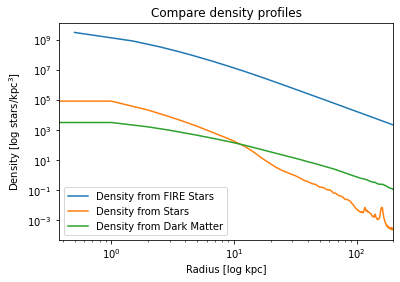

In [1241]:
# Compare built-in FIRE density to previous density 
fig, ax = plt.subplots()
ax.loglog(proStar['star'].get('distance.mid'),proStar['star'].get('density.cum'), label='Density from FIRE Stars')
ax.loglog(starEdges[:-1], starDensity, label='Density from Stars')
ax.loglog(darkEdges[:-1], darkDensity, label='Density from Dark Matter')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Compare density profiles')
plt.show()

# Check velocity distribution

In [1242]:
# Ensure velocities are with respect to the galactic center by graphing with respect to distance 
# (bin by shell and do means instead of sums)
# radial velocity

In [1243]:
# Declare function to calculate mean velocity
def mean(vel, pos, n_bins, rmax):
    dr = np.linspace(0, rmax, n_bins)
    r = (pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)**0.5 # convert pos vector to scalar
    v = (vel[:,0]**2 + vel[:,1]**2 + vel[:,2]**2)**0.5 # convert vel vector to scalar
    vel_dr = np.zeros(len(dr)-1)
    for i in range(len(dr)-1):
        index = np.where((r<dr[i+1]) & (r>dr[i]))
        vel_dr[i] = np.mean(v[index])
    return dr, vel_dr

In [1244]:
# Find mean velocity distribution
shellRadius, shellVelocity = mean(starVel, starPos, n_bins=100, rmax=rmax)

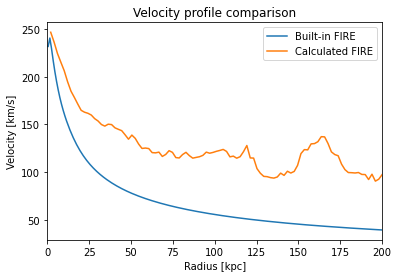

In [1245]:
# Compare velocity profiles
fig, ax = plt.subplots()
ax.plot(proStar['star'].get('distance.mid'),proStar['star'].get('vel.circ'), label='Built-in FIRE')
ax.plot(shellRadius[1:], shellVelocity, label='Calculated FIRE')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity [km/s]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Velocity profile comparison')
plt.show()

# Dark matter inner region

In [1246]:
# Linear binning from 0 to 200 kpc with 1 kpc bin width, assuming a 3-D profile
SpeciesProfileInner = ut.particle.SpeciesProfileClass(
    limits=[0, 20], width=1, log_scale=False, dimension_number=3)
proDarkInner = SpeciesProfileInner.get_sum_profiles(part, 'dark', 'mass')


# in utilities.particle.SpeciesProfile():
  input 70514272 distances -  3445090 (4.9%) are within limits = [0.000, 20.000]


In [1247]:
# Find mean velocity distribution
shellRadius, shellVelocity = mean(darkVel, darkPos, n_bins=100, rmax=20)

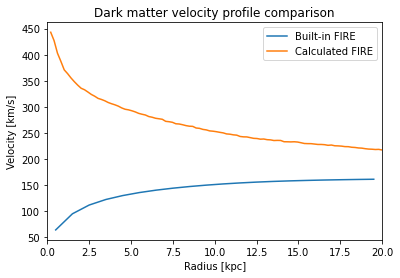

In [1250]:
# Compare dark mattervelocity profiles
fig, ax = plt.subplots()
ax.plot(proDarkInner['dark'].get('distance.mid'),proDarkInner['dark'].get('vel.circ'), label='Built-in FIRE')
ax.plot(shellRadius[1:], shellVelocity, label='Calculated FIRE')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity [km/s]')
ax.set_xlim(rmin, 20)
ax.legend()
plt.title('Dark matter velocity profile comparison')
plt.show()

# Additional velocity graphs

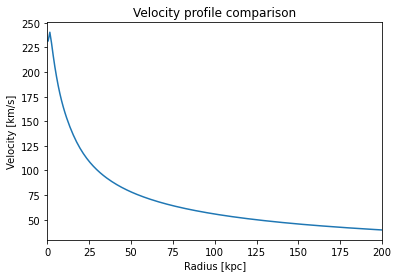

In [1251]:
# Compare velocity profiles
fig, ax = plt.subplots()
ax.plot(proStar['star'].get('distance.mid'),proStar['star'].get('vel.circ'), label='FIRE velocity')
ax.set_xlabel('Radius [kpc]')
ax.set_ylabel('Velocity [km/s]')
ax.set_xlim(rmin, rmax)
plt.title('Velocity profile comparison')
plt.show()